# LunarLander

Exploring the `LunarLander-v2` environment from the Open Gym 

There are 8 states: the **position** (x,y), **velocity** (vx,vy), **orientation** (angle, its angular velocity), **two booleans** that represent whether each leg is in contact with the ground or not.

There are **four discrete actions**: (do nothing, fire left engine, fire main engine, fire right engine).

- Reward for landing pad and coming to rest is about **100-140** points
- If it comes to rest, it receives an additional **+100** points
- Each leg with ground contact is **+10** points.
- Firing the main engine is **-0.3** points each frame. 
- Firing the side engine is **-0.03** points each frame.
- If the lander crashes, it receives an additional **-100** points

## Import libraries and create an environment

space:  (8,) float32
low:    [-inf -inf -inf -inf -inf -inf -inf -inf]
high:   [inf inf inf inf inf inf inf inf]
actions: 4 int64
obs: [ 0.00211143  1.4118983   0.21385045  0.0434727  -0.00243984 -0.04844033
  0.          0.        ]


c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\pyglet\image\codecs\wic.py:406: UserWarning: [WinError -2147417850] Изменение режима для потока после его установки невозможно
  warnings.warn(str(err))


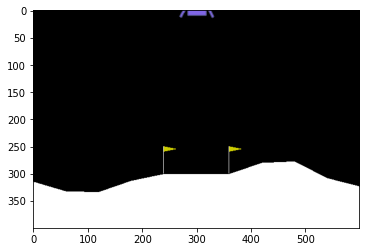

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import gym                                      # OpenAI Gym library
env = gym.make('LunarLander-v2')                # create an environment

space = env.observation_space                     # observation space
print("space: ", space.shape, space.dtype)        # space dimension and type
print("low:   ", space.low)                       # minimum values
print("high:  ", space.high)                      # maximum values

actions = env.action_space                        # action space
print("actions:", actions.n, actions.dtype)       # number of actions, type

obs = env.reset()                               # initial observation on the system
print('obs:', obs) 
plt.imshow(env.render('rgb_array'))             # render the environment as image 
env.close()

In [31]:
env.close()

## Save Video

In [24]:
import torch
import torch.nn as nn

class AgentModel(nn.Module):
    """ Neural network for Q(s,a) """
    def __init__(self, nS, nA, hiddens):
        super(AgentModel, self).__init__()
        
        neurons, layers = [nS] + hiddens + [nA], []        
        for i in range(len(neurons)-1):
            layers.append(nn.Linear(neurons[i], neurons[i+1]) )
            if i < len(neurons)-2:
                layers.append( nn.ReLU() )
        
        self.model = nn.Sequential(*layers)
 
    def forward(self, x):
        return self.model(x)        

In [26]:
model = AgentModel( 8, 4, [ 256, 128] )
print(model)
state  = torch.load('models/LunarLander-v2_256_128.278.pt')   
print(state['model'])
model.load_state_dict(state['state'])   

AgentModel(
  (model): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=4, bias=True)
  )
)
AgentModel(
  (model): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=4, bias=True)
  )
)


<All keys matched successfully>

In [27]:
def policy(state):    
    x = torch.tensor(state, dtype=torch.float32)
    with torch.no_grad():
        y = model(x).detach().to('cpu').numpy() 
    return np.argmax(y)     

In [40]:
from PIL import Image, ImageDraw, ImageFont
import imageio

def render_frame(frame, text: str):
    """
    Get frame with overwritten text:
    """
    im = Image.fromarray(frame)
    if text:        
        drawer = ImageDraw.Draw(im)    
        text_color = (255,255,255) if np.mean(im) < 128 else (0,0,0)
        font = ImageFont.truetype("verdana.ttf", 18)
        drawer.text((10, 10), text, fill=text_color, font=font)             
        font = ImageFont.truetype("verdana.ttf", 14)
        drawer.text((im.size[0]-100,im.size[1]-20), "QuData.com", fill=(0,255,0), font=font)
    return im


frames, last = [], 0
for episode in range(1, 11):
    rew, wait = 0, 0
    s = env.reset()                        
    for t in range(1, 301):       
        a = policy(s)                 
        s, r, done, _ = env.step(a) 
        rew += r
        
        if done:
            last = rew

        frame = env.render(mode='rgb_array') 
        frame = render_frame(frame, f"Episode:{episode:2d},  t:{t:5d},  reward: {last:3.0f},  <reward>=278")
        frames.append(frame)
    
        if done:    
            break                

imageio.mimwrite("render.mp4", frames, fps=60)            
env.close()

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
